# <center> MALAP: toxic comment classification challenge

#### <center> CHAUSSONNIER Romain, PHAM Manh-Dan, RAUDE Charles, SADE Adrien, VISCONTI François

In [ ]:
# mounting GoogleDrive for Colab
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  FOLDERNAME = "Projet_MALAP"
  %cd /content/gdrive/My\ Drive/$FOLDERNAME
except ImportError:
  pass

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/19xdDjI9VmhwUdkFetyipSISgkXWTTEy4/Projet_MALAP


# Introduction

In this project, we are working on the competitive challenge named Toxic Comment Classification on Kaggle. The aim of the challenge is to build a multi-headed model that is capable of detecting different types of toxic comments. The prediction that is needed for Kaggle is a probability for each of the six possible types of comment toxicity (toxic, severe toxic, obscene, threat, insult, identity hate).

# I- Database

> The database used to train and evaluate the different models we have tried is a dataset of comments taken from Wikepedia's talk page edits. 

First let's import some packages that are needed to deal with the database, from loading to visualization packages.




In [ ]:
# importing some packages
import pandas as pd
import numpy as np

import re
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# importing the training dataset
train_data = pd.read_csv("train.csv")
train_data.drop(['id'], axis=1, inplace=True)

# printing out the head of the table
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
# importing the testing set
test_data = pd.read_csv("test.csv")
test_data.drop(["id"], axis=1, inplace=True)
# printing the head of the table
test_data.head()

,comment_text
0,Yo bitch Ja Rule is more succesful then you'll...
1,== From RfC == \n\n The title is fine as it is...
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,":If you have a look back at the source, the in..."
4,I don't anonymously edit articles at all.


>**Comment** By looking at the raw database, we can see that there is a need to clean the database in order to make it possible to train different types of datastructures. Indeed, there are several characters that do not help at all to understand the toxicity of a comment. For instance the strings "\n" or "=="... The cleaning of the database will be done in the second part after having visualized the database using wordclouds.

>>**Note** We have decided to remove the "id" column because it contains no information whatsoever on the toxicity of the comment in question.

In [ ]:
# showing the first toxic comments
train_data.loc[train_data["toxic"]==1].head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


> **Comment** By showing the first toxic comments, we can see that the classes are not exclusive.

In [ ]:
# printing some characteritics/statistics of the training set

train_data["clean"] = 1.0 * (train_data.iloc[:, 1:].sum(axis=1) == 0) # creating a column to tell whether a comment is clean or not
print("Total number of comments: {} \n".format(len(train_data)))
print("Total number of clean comments: {} \n".format(int(train_data['clean'].sum())))

tagged = train_data.iloc[:, 1:-1].sum()
names = ["toxic", "severe toxic", "obscene", "threat", "insult", "identity hate"]
for (index, name) in enumerate(names):
  print("Total number of {} comments: {}".format(name, tagged[index]))
print("Total number of tags: {}".format(tagged.sum()))

Total number of comments: 159571 

Total number of clean comments: 143346 

Total number of toxic comments: 15294
Total number of severe toxic comments: 1595
Total number of obscene comments: 8449
Total number of threat comments: 478
Total number of insult comments: 7877
Total number of identity hate comments: 1405
Total number of tags: 35098


>**Comment** The database under study is very large. Morover, the number of clean comments is much larger than the number of different toxic comments.

## I- 1.  Word Cloud representation of the database

>In this section, we have plotted in wordclouds the words that appeared the most in the different classes.

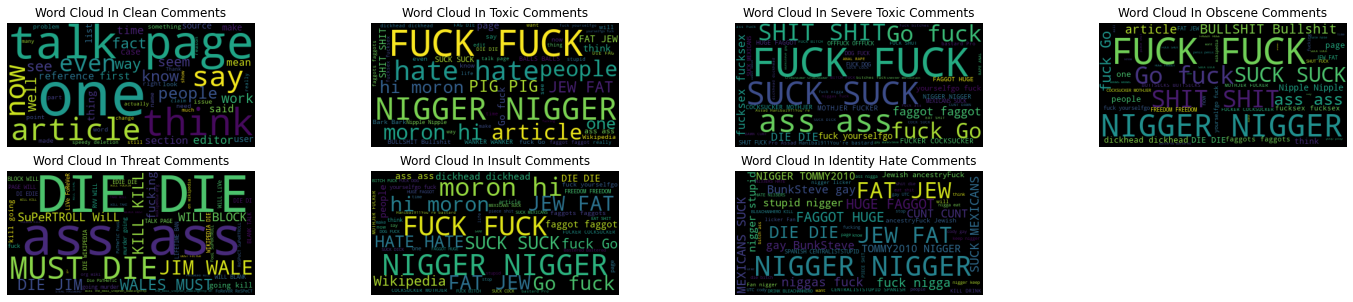

In [ ]:
stopword = set(STOPWORDS)

fig = plt.figure(figsize=(25, 5))
# clean comments
clean = train_data[train_data.clean == True]
text = clean.comment_text.values
wc = WordCloud(max_words=50, stopwords=stopword)
wc.generate(", ".join(text))
fig.add_subplot(2, 4, 1)
plt.axis("off")
plt.title("Word Cloud In Clean Comments")
plt.imshow(wc)

# toxix comment
toxic = train_data[train_data.toxic == 1]
text = toxic.comment_text.values
wc = WordCloud(max_words=50, stopwords=stopword)
wc.generate(", ".join(text))
fig.add_subplot(2, 4, 2)
plt.axis("off")
plt.title("Word Cloud In Toxic Comments")
plt.imshow(wc)

# severe toxic
severe_toxic = train_data[train_data.severe_toxic == 1]
text = severe_toxic.comment_text.values
wc = WordCloud(max_words=50, stopwords=stopword)
wc.generate(", ".join(text))
fig.add_subplot(2, 4, 3)
plt.axis("off")
plt.title("Word Cloud In Severe Toxic Comments")
plt.imshow(wc)

# obscene
obscene = train_data[train_data.obscene == 1]
text = obscene.comment_text.values
wc = WordCloud(max_words=50, stopwords=stopword)
wc.generate(", ".join(text))
fig.add_subplot(2, 4, 4)
plt.axis("off")
plt.title("Word Cloud In Obscene Comments")
plt.imshow(wc)

# threat
threat = train_data[train_data.threat == 1]
text = threat.comment_text.values
wc = WordCloud(max_words=50, stopwords=stopword)
wc.generate(", ".join(text))
fig.add_subplot(2, 4, 5)
plt.axis("off")
plt.title("Word Cloud In Threat Comments")
plt.imshow(wc)

# insult
insult = train_data[train_data.insult == 1]
text = insult.comment_text.values
wc = WordCloud(max_words=50, stopwords=stopword)
wc.generate(", ".join(text))
fig.add_subplot(2, 4, 6)
plt.axis("off")
plt.title("Word Cloud In Insult Comments")
plt.imshow(wc)

# identity hate
identity_hate = train_data[train_data.identity_hate == 1]
text = identity_hate.comment_text.values
wc = WordCloud(max_words=50, stopwords=stopword)
wc.generate(", ".join(text))
fig.add_subplot(2, 4, 7)
plt.axis("off")
plt.title("Word Cloud In Identity Hate Comments")
plt.imshow(wc)

>**Comment** There seems to be words that are characteristic of each class. This motivates our approach with word embedding. In order to detect whether a comment is toxic or not, we think that detecting these words will be enough. Thus contrarily to sentiment extraction, we assume that we don't need the grammatical structure of the comments.

## I- 2. Cleaning the database


In [ ]:
# importing some packages
import nltk
nltk.download("stopwords")
nltk.download("punkt")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def clean_text(text):
    # transforming text in lowercaps
    text = text.lower()
    # taking out special symbols
    text = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', text) # clean url
    text = re.sub(r'#(\w+)', '', text)   # clean hashes
    text = re.sub(r'@(\w+)', '', text)   # clean @
    text = re.sub(r'<[^>]+>', '', text)  # clean tags
    text = re.sub(r'\d+', '', text)      # clean digits
    text = re.sub(r'[,!@\'\"?\.$%_&#*+-:;]', '', text)   # clean punctuation
    text = re.sub(r'==', '', text)    #clean ==
    text = re.sub(r'\(', '', text)   #clean (
    text = re.sub(r'\)', '', text)   #clean )
    text = re.sub(r'·', '', text)   #clean ·
    text = re.sub(r'•', '', text)   #clean •
    text = re.sub(r'|', '', text)   #clean |
    text = re.sub(r'\[', '', text)   #clean [
    text = re.sub(r'\]', '', text)   #clean ]
    text = re.sub(r'>', '', text)   #clean >
    text = re.sub(r'<', '', text)   #clean <
    text = re.sub(r'=', '', text)   #clean =
    text = re.sub(r'“', '', text)   #clean “
    text = re.sub(r"'", '', text)   #clean '
   
  
    # removing stop words from the different sentences
    stop_words = set(stopwords.words("english"))
    words = nltk.word_tokenize(text)
    text = [word for word in words if not word in stop_words]
    text = str(text).strip('[]')

    return text

In [ ]:
# applying the clean_text function to the training dataset and the testing dataset
train_data["comment_text"] = train_data["comment_text"].apply(clean_text)
test_data["comment_text"] = test_data["comment_text"].apply(clean_text)

In [ ]:
# printing out the head of the cleaned train database
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,"'explanation', 'edits', 'made', 'username', 'h...",0,0,0,0,0,0,1.0
1,"'daww', 'matches', 'background', 'colour', 'im...",0,0,0,0,0,0,1.0
2,"'hey', 'man', 'im', 'really', 'trying', 'edit'...",0,0,0,0,0,0,1.0
3,"'cant', 'make', 'real', 'suggestions', 'improv...",0,0,0,0,0,0,1.0
4,"'sir', 'hero', 'chance', 'remember', 'page', '...",0,0,0,0,0,0,1.0


In [ ]:
# printing out the head of the cleaned test database
test_data.head()

,comment_text
0,"'yo', 'bitch', 'ja', 'rule', 'succesful', 'you..."
1,"'rfc', 'title', 'fine', 'imo'"
2,"'sources', 'zawe', 'ashton', 'lapland', '—'"
3,"'look', 'back', 'source', 'information', 'upda..."
4,"'dont', 'anonymously', 'edit', 'articles'"


## I- 3. Vectorizing the database

> We vectorized the database using a Text Frequency Inverse Document Frequency vectorizer (TfidfVectorizer) instead of a simple count of words. The goal of using tf-idf instead of the raw frequencies of occurrence in a given comment is to scale down the impact of words that occur very frequently throughout the whole set of comments and that are hence less informative than features that occur in a small fraction of the set of comments.

In [ ]:
# imports of packages to vectorize the database
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, validation_curve, learning_curve
from scipy.sparse import hstack

In [ ]:
class_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

train = train_data
test = test_data

In [ ]:
train_text = train["comment_text"]
test_text = test["comment_text"]

In [ ]:
# creating the features associated with each comments
word_vectorizer = TfidfVectorizer(sublinear_tf=True,
                                  strip_accents='unicode',
                                  analyzer='word',
                                  token_pattern=r'\w{1,}',
                                  stop_words='english',
                                  ngram_range=(1, 1),
                                  max_features=10000)
word_vectorizer.fit(train_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

> **Remark** 
Given that the classes are not exclusive (a comment can be both toxic and obscene for instance), we decided to do a binary classification for each class instead of a single multi-class classification.
Moreover, for cross validation, we used the function cross_val_score from sklearn that performs a k-fold and returns the vector of the accuracy of the classifier on each fold.

# II- First approach using trees and forests


## II- 1. Trees


> The first classifier we tested is a decision tree because this classifier allows a clear interpretation of its decision path.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

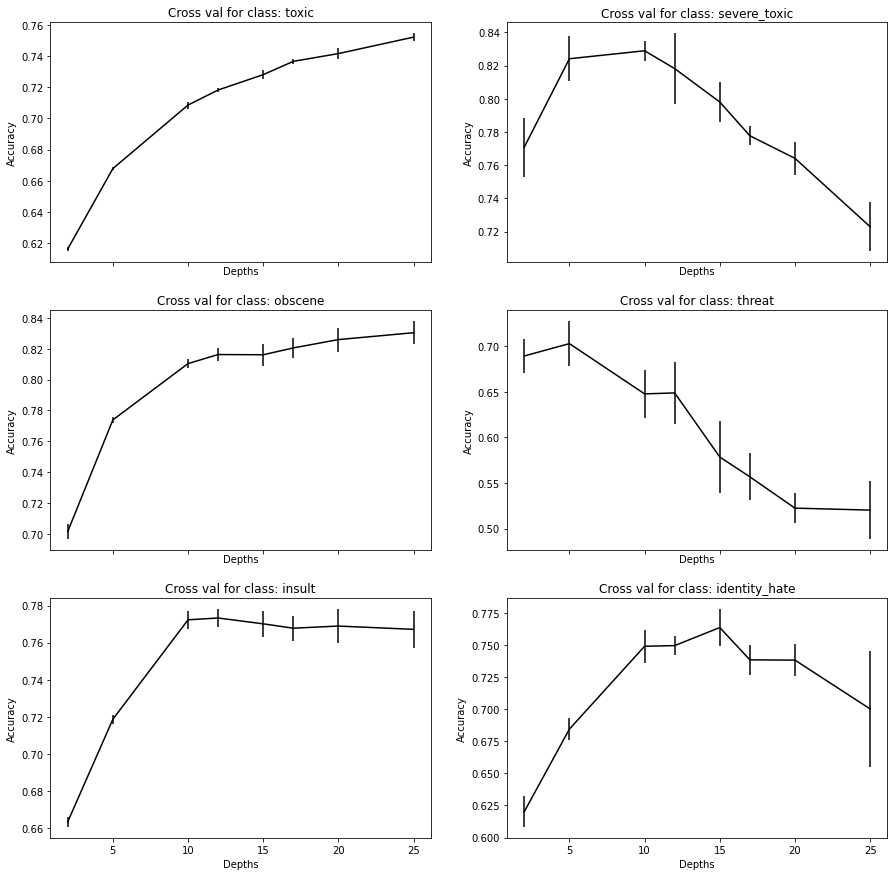

In [ ]:
# Choosing the optimal depth for a tree through cross-validation

depths = [2, 5, 10, 12, 15, 17, 20, 25]

@ignore_warnings(category=ConvergenceWarning)
def cross_val():
  fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, squeeze=False, figsize=(15,15))
  for i, class_name in enumerate(class_names):
      ax = axes[i//2, i%2]
      train_target = train[class_name]
      mean_scores = []
      std_scores = []
      for depth in depths:
          clf = DecisionTreeClassifier(max_depth=depth)
          score = cross_val_score(clf, train_word_features, train_target, cv=3, scoring="roc_auc")

          mean_scores.append(np.mean(score))
          std_scores.append(np.std(score))

      ax.errorbar(depths, mean_scores, std_scores, fmt='-k')
      ax.set_title("Cross val for class: {}".format(class_name))
      ax.set_xlabel("Depths")
      ax.set_ylabel("Accuracy")
  plt.show()

cross_val()

>**Comment** First of all, we can see that the best value for the depth vary a lot from one class to another. Indeed, the accuracy globally increases with the depths for most classes but it is for instance not the case for the threat class. As we have seen in class, decision trees often tend to overfit for higher depths (it can for instance be seen with the graph for the identity hate or the threat class). 

In [ ]:
best_depths = [25, 10, 25, 5, 12, 15]
scores = []

submission = pd.read_csv("test.csv")

for idx, class_name in enumerate(class_names):
  train_label = train_data[class_name]

  classifier = DecisionTreeClassifier(max_depth=best_depths[idx])
  cv_score = np.mean(cross_val_score(classifier, train_word_features, train_label, cv=3, scoring='roc_auc'))
  scores.append(cv_score)
  print('CV score for class {} is {}'.format(class_name, cv_score))

  classifier.fit(train_word_features, train_label)
  submission["{}".format(class_name)] = classifier.predict_proba(test_word_features)[:, 1]
  
  # We export the tree to a pdf file
  tree_graph = export_graphviz(classifier, out_file=None, max_depth=6, 
                                    feature_names = word_vectorizer.get_feature_names(),   
                                    class_names=['other', class_name], 
                                    filled=True, rounded=True, rotate=True,
                                    special_characters=True)
  
  graph = graphviz.Source(tree_graph)
  graph.render("comment classif_{}".format(class_name))

print('Total CV score is {}'.format(np.mean(scores)))
submission.drop(["comment_text"], axis=1, inplace=True)
submission.to_csv("test_decision_tree.csv", index=False)

CV score for class toxic is 0.7509167383491757
CV score for class severe_toxic is 0.8289864288827742
CV score for class obscene is 0.826180143956538
CV score for class threat is 0.7027249268326776
CV score for class insult is 0.7749426801406507
CV score for class identity_hate is 0.7588939969653691
Total CV score is 0.7737741525211975


>**Comment** Here, we have printed some scores only in order to get an idea of the results obtained by the different classifiers. By submitting the .csv file we obtained thanks to all the different classifiers, we get the following score on Kaggle: **0.80656**.

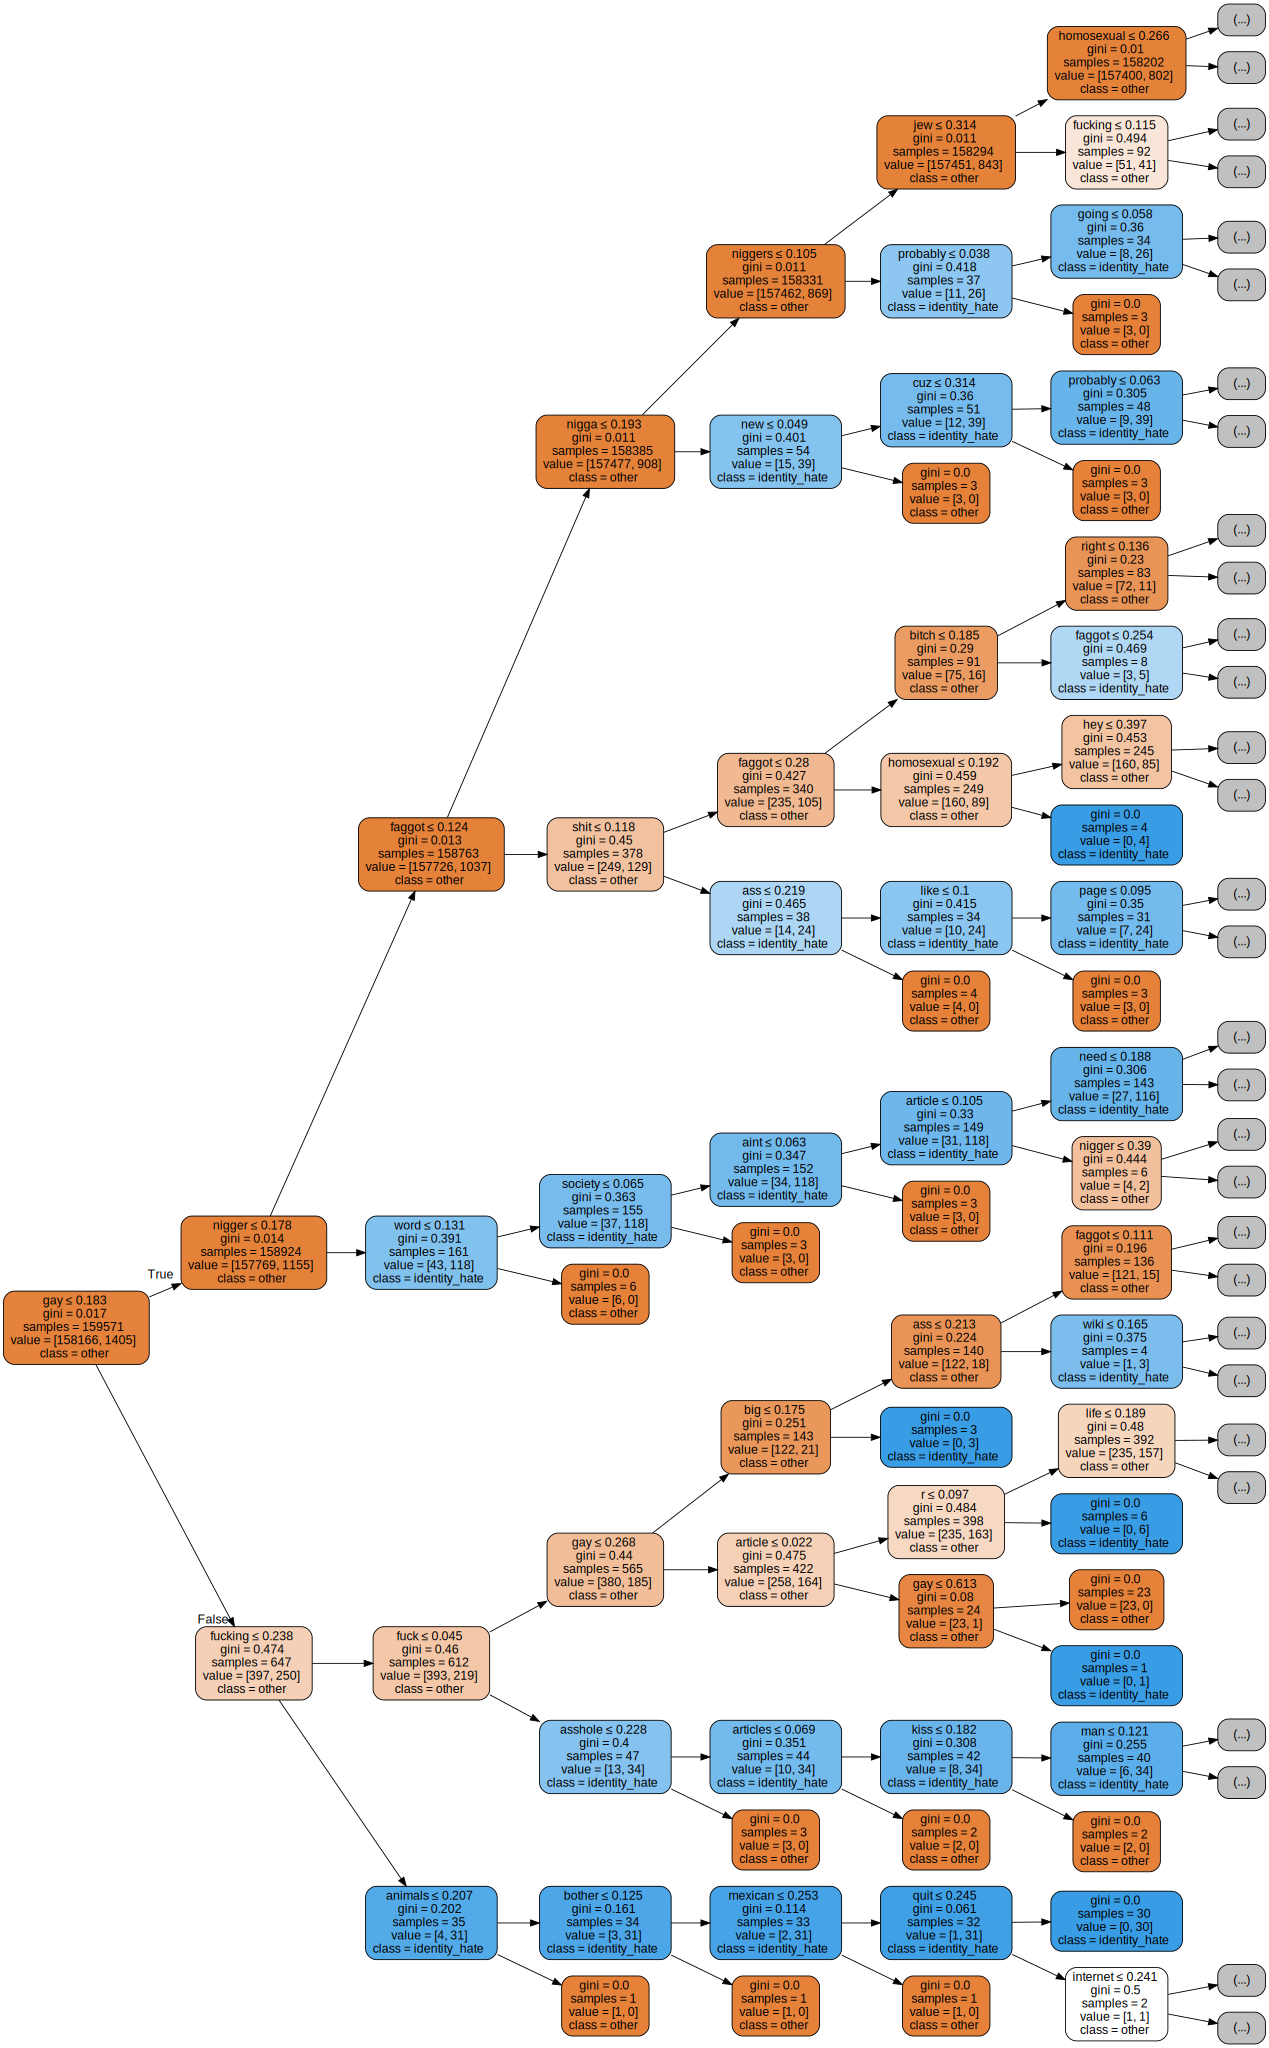

In [ ]:
# plot the associated graph of the tree for the identity hate class
graph

>**Comment** On the graph above, we have plotted the graph corresponding to the decision tree for the binary classification on the identity hate class. Here, the first two important dimensions for the split are the words "gay" and "ni**er", which are known to be commonly used insults for identity hate. By following the tree path, one can understand which features the tree decided to look at for the classification.

You can find the other graphs in the folder (Tree_Results).

## II- 2. Forest

We've seen in class that trees tend to perform poorly. Thus we decided to use a random forest.


The approach here is still the same. Instead of considering the problem as a multi-classification problem, we have decided to train a random forest for each class in order to get better results than in the previous section where we only looked at one tree. We used the RandomForestClassifier class of sklearn.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


Sklearn's RandomForestClassifier is a random forest classifier that consists of 100 trees. We have decided to do a cross-validation (3-fold) on the depths of the trees that make the Random Forest.

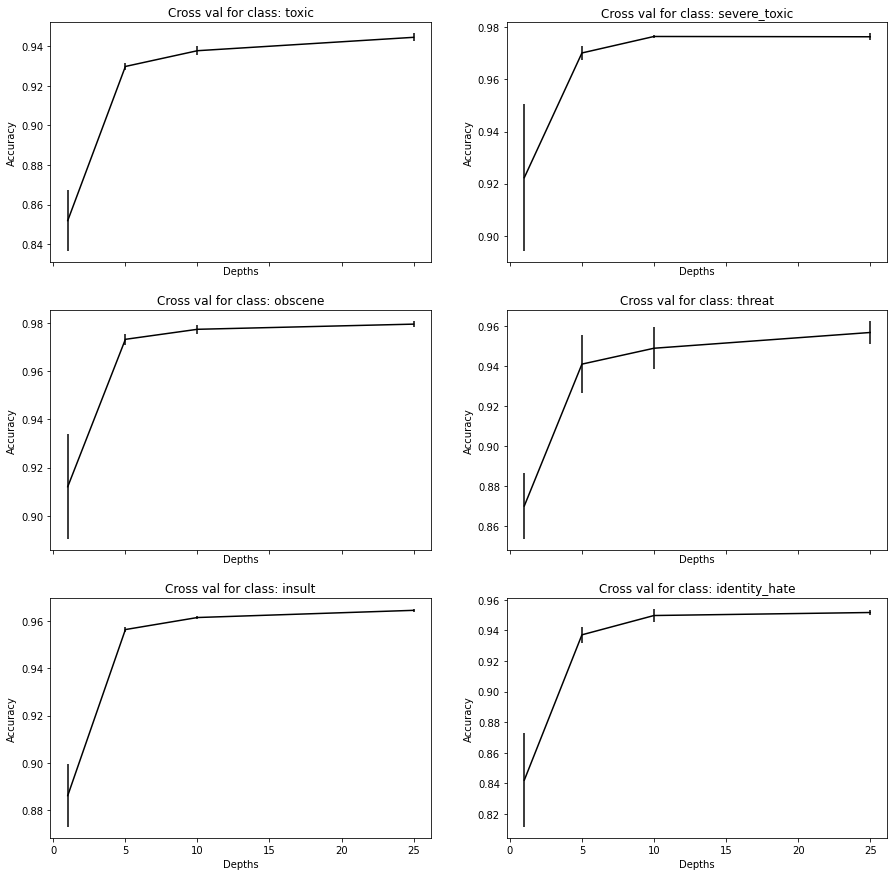

In [ ]:
Depths = [1, 5, 10, 25]

@ignore_warnings(category=ConvergenceWarning)
def cross_val():
  fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, squeeze=False, figsize=(15,15))
  for i, class_name in enumerate(class_names):
      ax = axes[i//2, i%2]
      train_target = train[class_name]
      mean_scores = []
      std_scores = []
      for depth in Depths:
          clf = RandomForestClassifier(max_depth=depth, random_state=0)
          score = cross_val_score(clf, train_word_features, train_target, cv=3, scoring="roc_auc")

          mean_scores.append(np.mean(score))
          std_scores.append(np.std(score))

      ax.errorbar(Depths, mean_scores, std_scores, fmt='-k')
      ax.set_title("Cross val for class: {}".format(class_name))
      ax.set_xlabel("Depths")
      ax.set_ylabel("Accuracy")
  plt.show()

cross_val()

>**Comment** Cross-validation results looks similar for all the different classes (accuracy increases with depths). Interestingly, the results obtained are different in accuracies. For instance, the results obtained for the obscene class and the severe toxis class are much better compared to other classes such as toxic. We believe that it is due to the fact that the toxic class is much more general and that is why the results obtained are slightly worse, thus Random Forest perform better on more specific classes such as the obscene class. We have decided to cross-validate on depths that go from 1 to 25 because we felt that 25 was a good trade-off in terms of training time versus the accuracy obtained.


We now train the different Random Classifier for each classes with the optimal depths obtained thanks to cross-validation. 

In [ ]:
best_depths = [25, 25, 25, 25, 25, 25]
scores = []
submission = pd.read_csv("test.csv")

for (index, class_name) in enumerate(class_names):
    train_target = train[class_name]
    clf = RandomForestClassifier(max_depth=best_depths[index], random_state=0)
    cv_score = np.mean(cross_val_score(clf, train_word_features, train_target, cv=3, scoring="roc_auc"))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_word_features, train_target)
    submission["{}".format(class_name)] = classifier.predict_proba(test_word_features)[:, 1]

print("Total CV score is {}".format(np.mean(scores))) 
submission.drop(["comment_text"], axis=1, inplace=True)
submission.to_csv("test_random_forest.csv", index=False)

CV score for class toxic is 0.9445536672561232
CV score for class severe_toxic is 0.9763612217287027
CV score for class obscene is 0.9794854173569542
CV score for class threat is 0.9567514592449723
CV score for class insult is 0.9645906975948249
CV score for class identity_hate is 0.9516670132336819
Total CV score is 0.9622349127358766


>**Comment** Here, we have printed some scores only in order to get an idea of the results obtained by the different classifiers. By submitting the .csv file we obtained thanks to all the different classifiers, we get the following score on Kaggle: **0.96486**

# III- Second approach using logistic regressions

Even if the results we obtained with the random forest are quite good, we have decided to try and test to train a logistic regression with the same approach by considering one classifier for each comment class ("toxic", "severe toxic", "obscene", "threat", "insult", "identity hate"). In order to do so, we used the LogisticRegression class of sklearn.



## III - 1) $l_2$ penalization

The logistic regression we have decided to train is a binary class $l_2$ binary class penalized regression that minimizes the following cost function:

$$
  \min_{w, c} \dfrac{1}{2}w^T w + C \sum_{i= 1}^n \log\left( \exp\left(-y_i(X_i^Tw + c)\right) + 1\right)
$$

Where $C>0$ is a parameter that needs to be tuned. That is why we have decided to perform a cross-validation on this parameter (5 fold) for the following values of C: $[10^{-3}, 10^{-2}, 10^{-1}, 1, 10, 100]$ 

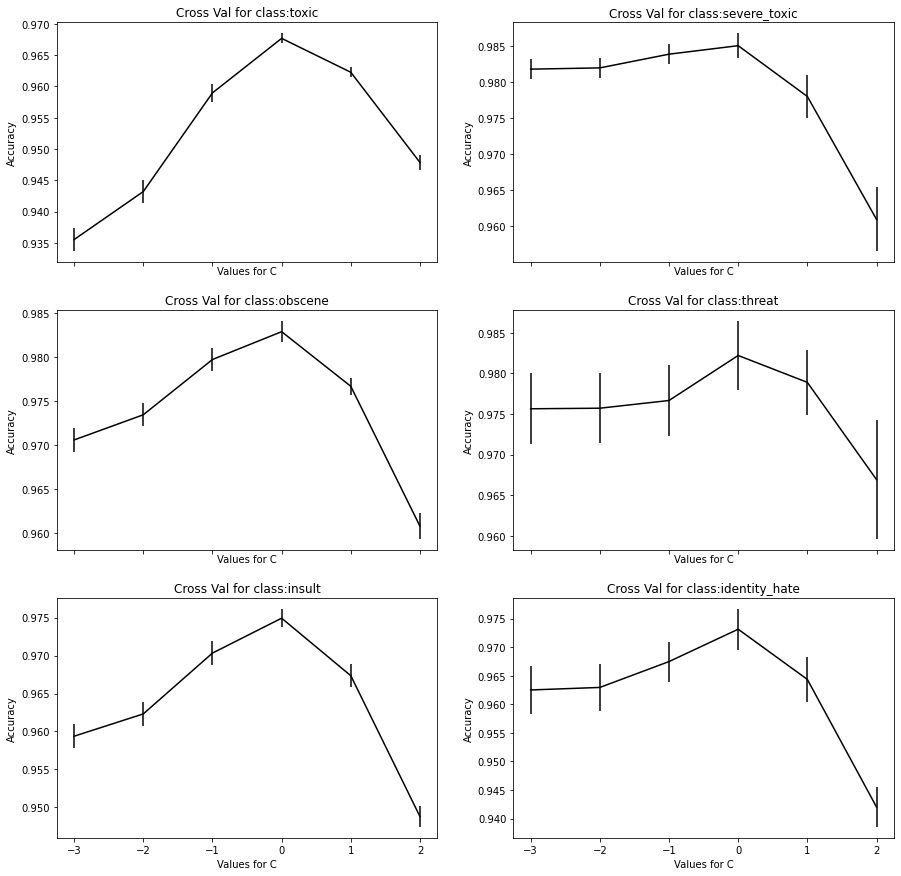

In [ ]:
C_list = [1e-3, 1e-2, 1e-1, 1, 10, 100]

@ignore_warnings(category=ConvergenceWarning)
def cross_val():
  fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, squeeze=False, figsize=(15,15))
  for i, class_name in enumerate(class_names):
      ax = axes[i//2, i%2]
      train_target = train[class_name]
      mean_score = []
      std_score = []
      for C in C_list:
          clf = LogisticRegression(C=C, solver="sag")

          score = cross_val_score(clf, train_word_features, train_target, cv=5, scoring="roc_auc")

          mean_score.append(np.mean(score))
          std_score.append(np.std(score))

      ax.errorbar(np.log10(C_list), mean_score, std_score, fmt='-k')
      ax.set_title("Cross Val for class:{}".format(class_name))
      ax.set_xlabel("Values for C")
      ax.set_ylabel("Accuracy")
  plt.show()
cross_val()

> **Comment** Again, it is interesting to note that the results of the cross-validation are really similar between all the different classes (in terms of the shape of the curve obtained). More importantly, looking at these graphs, it seems that the optimal value for $C$ obtained thanks to the cross-validation procedure is $C=1$.

Let us train the different classifiers using the optimal parameter $C=1$.

In [ ]:
# Training with C = 1
scores = []
submission = pd.read_csv("test.csv")
for class_name in class_names:
    train_target = train[class_name]
    classifier = LogisticRegression(C=1, solver="sag")

    cv_score = np.mean(cross_val_score(classifier, train_word_features, train_target, cv=3, scoring="roc_auc"))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_word_features, train_target)
    submission["{}".format(class_name)] = classifier.predict_proba(test_word_features)[:, 1]

print("Total CV score is {}".format(np.mean(scores)))  
submission.drop(["comment_text"], axis=1, inplace=True)
submission.to_csv("logistic_result_l2.csv", index=False)

CV score for class toxic is 0.966949714672284
CV score for class severe_toxic is 0.9846009262937779
CV score for class obscene is 0.9826087553231627
CV score for class threat is 0.9814440917325483
CV score for class insult is 0.9744011015345264
CV score for class identity_hate is 0.9730831628317569
Total CV score is 0.9771812920646762


> **Comment** Here, we have printed some scores only in order to get an idea of the results obtained by the different classifiers. By submitting the .csv file we obtained thanks to all the different classifiers, we get the following score on Kaggle: **0.97365**

## III - 2) $l_1$ penalization

We have also tried to train logistic regressions with a $l_1$ penalization. 

Here the cost function being minimized is:

$$\min_{w,c} \lVert w \rVert_1 + C\sum_{i=1}^n\log\left(\exp(\left(-y_i(X_i^Tw + c) \right) + 1 \right)$$

where $C>0$ is a similar tuning parameter. We thus perform a cross validation (5-fold) on the same values of C. 

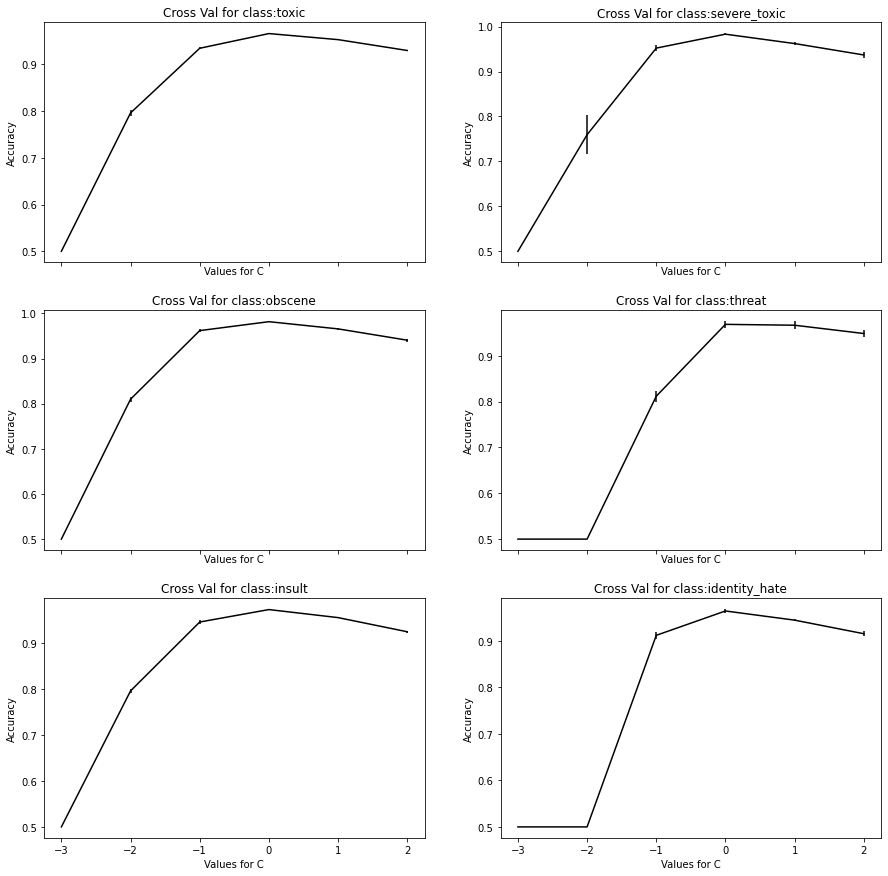

In [ ]:
C_list = [1e-3, 1e-2, 1e-1, 1, 10, 100]

@ignore_warnings(category=ConvergenceWarning)
def cross_val():
  fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, squeeze=False, figsize=(15,15))
  for i, class_name in enumerate(class_names):
      ax = axes[i//2, i%2]
      train_target = train[class_name]
      mean_score = []
      std_score = []
      for C in C_list:
          clf = LogisticRegression(penalty="l1", C=C, solver="liblinear")

          score = cross_val_score(clf, train_word_features, train_target, cv=5, scoring="roc_auc")

          mean_score.append(np.mean(score))
          std_score.append(np.std(score))

      ax.errorbar(np.log10(C_list), mean_score, std_score, fmt='-k')
      ax.set_title("Cross Val for class:{}".format(class_name))
      ax.set_xlabel("Values for C")
      ax.set_ylabel("Accuracy")
  plt.show()
cross_val()

Interestingly, the optimal value obtained are similar but the shape of the cross-validation curves are really different when comparing $l2$ penalty and $l1$ penalty. Let us train the $l1$ penalization logistic regression using the optimal values obtained for $C$.

In [ ]:
# Training with C = 1
scores = []
submission = pd.read_csv("test.csv")
for class_name in class_names:
    train_target = train[class_name]
    classifier = LogisticRegression(penalty="l1", C=1, solver="liblinear")

    cv_score = np.mean(cross_val_score(classifier, train_word_features, train_target, cv=3, scoring="roc_auc"))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_word_features, train_target)
    submission["{}".format(class_name)] = classifier.predict_proba(test_word_features)[:, 1]

print("Total CV score is {}".format(np.mean(scores)))  
submission.drop(["comment_text"], axis=1, inplace=True)
submission.to_csv("logistic_result_l1.csv", index=False)

CV score for class toxic is 0.9645428299980413
CV score for class severe_toxic is 0.9811932442377024
CV score for class obscene is 0.9812494922500323
CV score for class threat is 0.9656477547773075
CV score for class insult is 0.97228441585027
CV score for class identity_hate is 0.9631391765604125
Total CV score is 0.9713428189456277


> **Comment** Here, we have printed some scores only in order to get an idea of the results obtained by the different classifiers. By submitting the .csv file we obtained thanks to all the different classifiers, we get the following score on Kaggle: **0.97172**.

## III - 3) Elastic-Net

Finally, we tried to train a logistic regression using Elastic-Net regularization because it is a combination of $l_1$ and $l_2$ and could thus perform better than penalizing only on $l_1$ or $l_2$ norms. The cost function being minimized here is as follows:

$$ \min_{w,c} \dfrac{1-\rho}{2}w^Tw + \rho \lVert w \rVert_1 + C \sum_{i=1}^n \log\left((\exp\left(-y_i(X_i^Tw + c)\right) + 1 \right)$$

where $\rho$ controls the strength of $l_1$ regularization vs. $l_2$ regularization and $C>0$ is a tuning parameter. We can see that Elastic-Net is equivalent to $l_1$ when $\rho=1$ and equivalent to $l_2$ when $\rho = 0$. 

We have decided to first cross-validate on the value of $\rho$ for $C = 1$ as it was the best value for the previous logistic regression.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


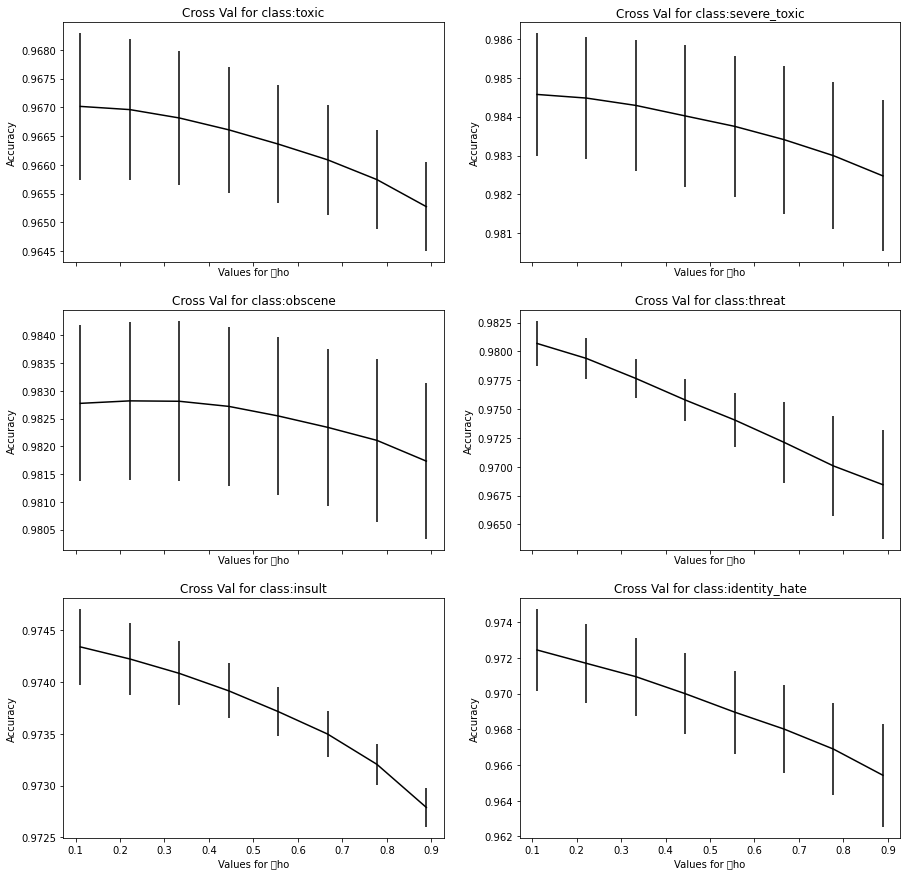

In [ ]:
rho_list = np.linspace(0, 1, 10)[1:-1]

@ignore_warnings(category=ConvergenceWarning)
def cross_val():
  fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, squeeze=False, figsize=(15,15))
  for i, class_name in enumerate(class_names):
      ax = axes[i//2, i%2]
      train_target = train[class_name]
      mean_score = []
      std_score = []
      for rho in rho_list:
          clf = LogisticRegression(penalty="elasticnet", C=1, solver="saga", l1_ratio=rho)

          score = cross_val_score(clf, train_word_features, train_target, cv=3, scoring="roc_auc")

          mean_score.append(np.mean(score))
          std_score.append(np.std(score))

      ax.errorbar(rho_list, mean_score, std_score, fmt='-k')
      ax.set_title("Cross Val for class:{}".format(class_name))
      ax.set_xlabel("Values for \rho")
      ax.set_ylabel("Accuracy")
  plt.show()
cross_val()

> **Comment** We can see that the best accuracies for all the classes corresponds to the lowest value for $\rho$ (ie. $\rho = 0.1$), so that the Elastic Net gives more importance to the $l_2$ regularization. This could be expected as previously, the logistic regression with $l_2$ penalization yielded better results than with $l_1$ penalization.


In [ ]:
rho = 0.1

scores = []

submission = pd.read_csv("test.csv")
for class_name in class_names:
    train_target = train[class_name]
    clf = LogisticRegression(penalty="elasticnet", C=1, solver="saga", l1_ratio=rho)

    cv_score = np.mean(cross_val_score(clf, train_word_features, train_target, cv=3, scoring="roc_auc"))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    clf.fit(train_word_features, train_target)
    submission["{}".format(class_name)] = clf.predict_proba(test_word_features)[:, 1]

print("Total CV score is {}".format(np.mean(scores)))  
submission.drop(["comment_text"], axis=1, inplace=True)
submission.to_csv("logistic_result_elastic_net.csv", index=False)

CV score for class toxic is 0.9670155188700109
CV score for class severe_toxic is 0.9845788887574188
CV score for class obscene is 0.9827638379970104
CV score for class threat is 0.9807927219016747
CV score for class insult is 0.9743491579396298
CV score for class identity_hate is 0.9725191771571557


> **Comment** Here, we have printed some scores only in order to get an idea of the results obtained by the different classifiers. By submitting the .csv file we obtained thanks to all the different classifiers, we get the following score on Kaggle: **0.97356**.

# Conclusion

Thanks to the different datastructures and machine learning techniques we used, we managed to get good results on the test set by uploading our submission files on Kaggle. The follwing table summarizes our results:

| ML Technique Used  | Scores obtained on Kaggle| 
| --- | --- |
| Decision Tree Classifier| 0.80656 | 
| Random Forest Classifier | 0.96486 | 
| Logistic Regression (l2 loss) | 0.97365 | 
|Logistic Regression (l1 loss)|0.97172|
|Logistic Regression (Elastic-Net)|0.97356|

We can see that the decision tree classifier performs poorly comparing to the other models. However, it is the most interpretable one (cf. pdf in the folder Tree_Result). Naturally, we have decided to train a random forest classifier which yielded excellent results. 

Then, we trained another family of classifiers: logistic regressions with different losses. They perform slighltly better than the Random Forest Classifier with similar computing times. 

This project showed us that deep learning was not the immediate answer to classification problems in nlp. Indeed, in our case, machine learning techniques perform well overall in addition to being more interpretable and understandable. 